In [40]:
# Guoqiang Tang
# Evaluate by reading metrics from statistical metrics
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import sys, glob, os, re, subprocess
import matplotlib
import matplotlib.pyplot as plt

def count_folders_in_directory(directory):
    return sum(os.path.isdir(os.path.join(directory, entry)) for entry in os.listdir(directory))


# Load Metrics

In [41]:
basins = []
for i in range(627):
    basins.append(f'level1_{i}')

In [42]:
# infiles
inpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich'
infilelist_stat = [f'{inpath}/{i}_OSTRICHcalib/archive/PreserveBestModel/trial_stats_allrecords.txt' for i in basins]
print('The number of stat files:', len(infilelist_stat))

infilelist_ostmodel = [f'{inpath}/{i}_OSTRICHcalib/archive/PreserveBestModel/OstModel0.txt' for i in basins]
print('The number of OstModel0.txt files:', len(infilelist_stat))

The number of stat files: 627
The number of OstModel0.txt files: 627


In [43]:
# Metrics from OstModel0.txt
num = len(infilelist_ostmodel)
meanerr_ost = np.nan * np.zeros([num, 2]) # default param kge and best param kge

for i in range(num):
    infile_OstModel = infilelist_ostmodel[i]

    if os.path.isfile(infile_OstModel):
        df_OstModel = pd.read_csv(infile_OstModel, delim_whitespace=True)
        df_OstModel['obj.function'] = df_OstModel['obj.function'].values.astype(float) # some times there is NaN string
        meanerr_ost[i, 0] = df_OstModel['obj.function'].values[0]
        meanerr_ost[i, 1] = df_OstModel['obj.function'].values[-1]

In [44]:
# Metrics from trial_stats_allrecords.txt

def read_trial_stats_allrecords(file_path):
    kge_values = []
    rmse_values = []
    mae_values = []
    maxmerr_values = []

    with open(file_path, 'r') as file:
        for line in file:
            if '#streamflow_KGE' in line:
                kge_value = float(line.split('#')[0].strip())
                kge_values.append(kge_value)
            elif '#streamflow_RMSE' in line:
                rmse_value = float(line.split('#')[0].strip())
                rmse_values.append(rmse_value)
            elif '#streamflow_abserr' in line:
                v = float(line.split('#')[0].strip())
                mae_values.append(v)
            elif '#streamflow_maxmontherr' in line:
                v = float(line.split('#')[0].strip())
                maxmerr_values.append(v)

    return np.array(kge_values), np.array(rmse_values), np.array(mae_values), np.array(maxmerr_values)

num = len(infilelist_ostmodel)
kge_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
rmse_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
mae_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge
maxmerr_stat = np.nan * np.zeros([num, 2]) # default param kge and best param kge

for i in range(num):
    infile_stat = infilelist_stat[i]

    if os.path.isfile(infile_stat):

        try:
            tmpkge, tmprmse, tmpmae, tmpmaxmerr = read_trial_stats_allrecords(infile_stat)
            
            kge_stat[i, 0] = tmpkge[0]
            kge_stat[i, 1] = tmpkge[-1]
            
            rmse_stat[i, 0] = tmprmse[0]
            rmse_stat[i, 1] = tmprmse[-1]
        
            mae_stat[i, 0] = tmpmae[0]
            mae_stat[i, 1] = tmpmae[-1]
        
            maxmerr_stat[i, 0] = tmpmaxmerr[0]
            maxmerr_stat[i, 1] = tmpmaxmerr[-1]

        except:
            print('wrong')

# Load basin information

In [45]:
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file)
df_info.head()

,hru_id,ann_P,lon_cen,lat_cen,AREA,elev_mean,ave_T,july_T,Perimeter,Source,...,RawTDXarea,HSTDXarea,MHTDXarea,RawCAMELSbias,RawTDXbias,HSTDXbias,MHTDXbias,final_bias,geometry,file_obsQ
0,1013500,0.0,-68.56551,47.01169,2.303988e+09,277.493490,NaN,NaN,647993,RawTDX,...,2246.946668,2246.628415,2246.132802,0.022767,-0.002554,-0.002695,-0.002915,0.002554,POLYGON ((-68.84000529335947 46.73746031546882...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
1,1022500,0.0,-68.07313,44.79691,6.203873e+08,103.604200,NaN,NaN,312624,HSTDX,...,615.173865,586.427404,586.602450,0.081568,0.072479,0.022363,0.022668,0.022363,POLYGON ((-68.13005554673525 44.64716666195261...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
2,1030500,0.0,-68.14985,45.80527,3.676155e+09,174.433896,NaN,NaN,662248,RawCAMELS,...,3654.475429,3653.788946,3653.845830,-0.000004,-0.005901,-0.006088,-0.006073,0.000004,POLYGON ((-68.35800170861474 45.67902755716805...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
3,1031500,0.0,-69.58119,45.23568,7.665447e+08,304.743490,NaN,NaN,309614,RawCAMELS,...,775.632787,772.001421,772.168545,-0.003258,0.008560,0.003838,0.004055,0.003258,POLYGON ((-69.67646789509475 45.14558029212971...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...
4,1047000,0.0,-70.16213,44.98744,9.049562e+08,379.779978,NaN,NaN,310157,RawCAMELS,...,914.491471,914.237495,913.814091,-0.004558,0.005931,0.005651,0.005185,0.004558,POLYGON ((-70.10847473135688 45.21669387774366...,/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/C...


# Plot

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

## Plot iteration number

In [80]:
trialnum = [count_folders_in_directory(f'{inpath}/{i}_OSTRICHcalib/archive/PreserveModelOutput') for i in basins]
trialnum = np.array(trialnum)
print(np.nanmean(trialnum))

103.63157894736842


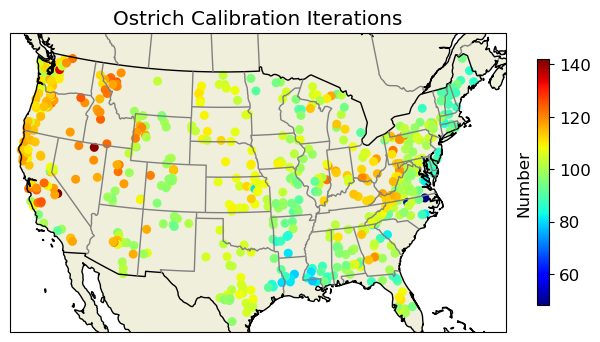

In [47]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[8, 4])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

ax = fig.add_subplot(1, 1, 1, projection=proj)
ax = set_background(ax)
p = ax.scatter(df_info['lon_cen'].values, df_info['lat_cen'].values, 30, trialnum, cmap='jet', transform=transf)
ax.set_title('Ostrich Calibration Iterations')
    
cax = plt.colorbar(p, ax=ax, label='Number', location='right', shrink=0.8)
cax.ax.yaxis.set_ticks_position('right')
cax.ax.yaxis.set_label_position('left')

# plt.savefig('Ostrich_iter_num.png', dpi=600, bbox_inches='tight', pad_inches=0)

## KGE map

In [57]:
print('defa / cali kge', np.nanmean(kge_stat,axis=0))
print('defa / cali kge', np.nanmedian(kge_stat,axis=0))

defa / cali kge [-1.21288644  0.24784226]
defa / cali kge [0.195203 0.358292]


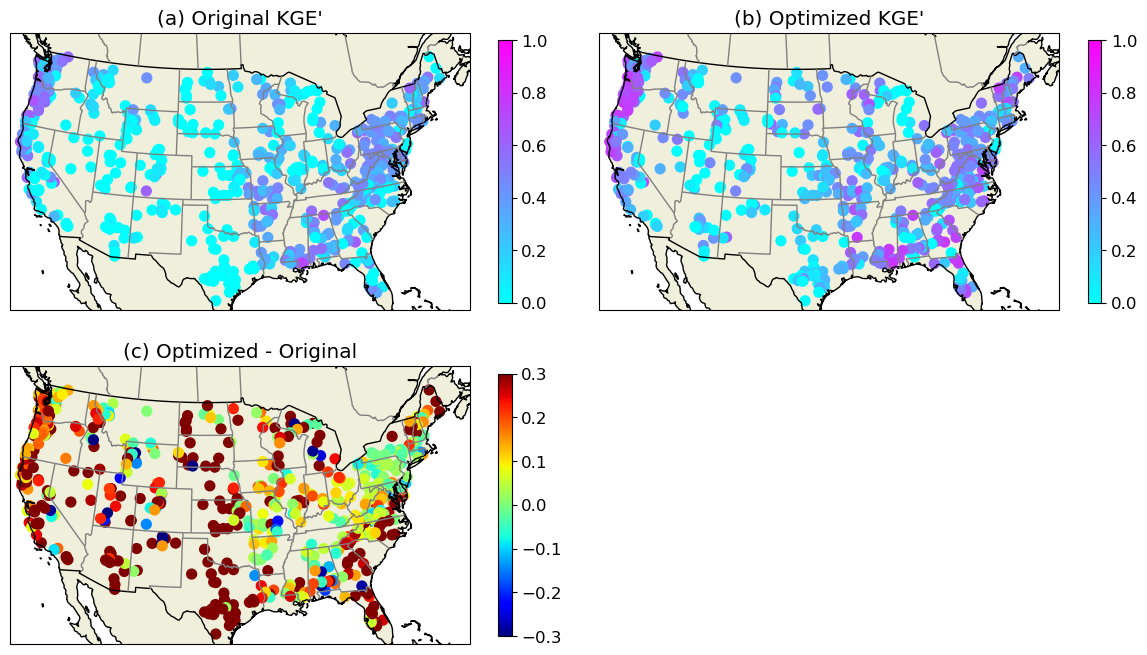

In [58]:
data = [kge_stat[:,0], kge_stat[:,1], kge_stat[:,1]-kge_stat[:,0]]
title = ["(a) Original KGE'", "(b) Optimized KGE'", "(c) Optimized - Original", "(d) Optimized - Original",]
cmaps = ['cool', 'cool', 'jet']
lims = [ [0, 1], [0, 1], [-0.3, 0.3]]


font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(df_info['lon_cen'].values, df_info['lat_cen'].values, 50, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
# plt.savefig('CAMELS_calib_kge.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

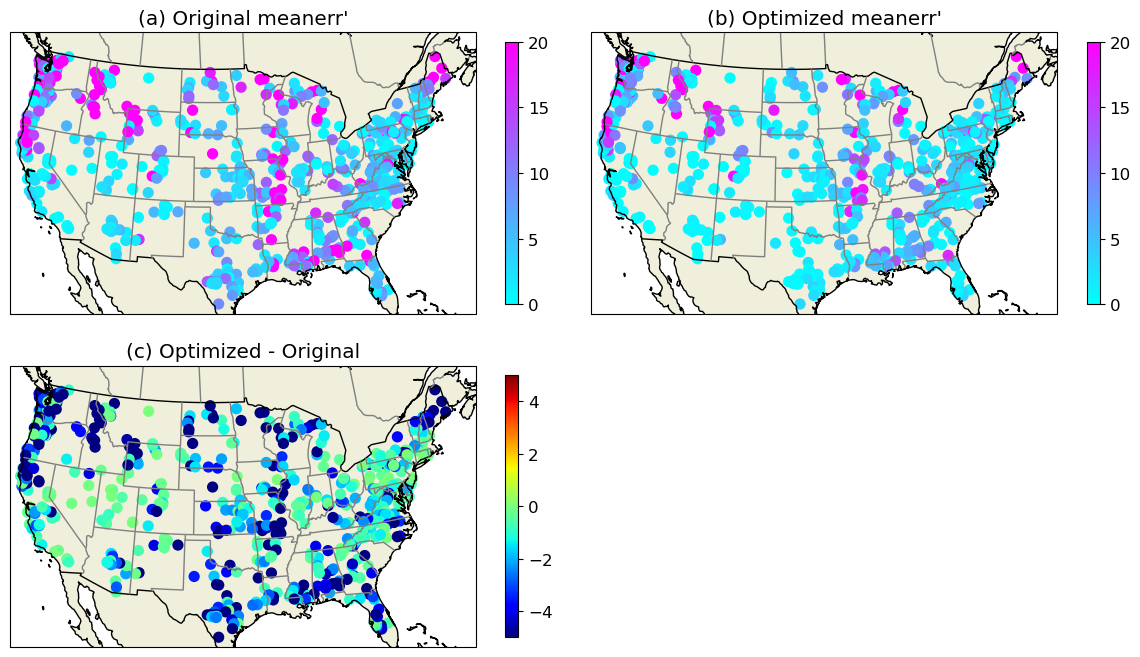

In [49]:
d1 = (maxmerr_stat[:,0]+mae_stat[:,0])/2
d2 = (maxmerr_stat[:,1]+mae_stat[:,1])/2
data = [d1, d2, d2-d1]
title = ["(a) Original meanerr'", "(b) Optimized meanerr'", "(c) Optimized - Original", "(d) Optimized - Original",]
cmaps = ['cool', 'cool', 'jet']
lims = [ [0, 20], [0, 20], [-5, 5]]


font = {'size'   : 12}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[12, 7])

proj = ccrs.AlbersEqualArea(central_longitude=-100)
transf = ccrs.PlateCarree()

for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection=proj)
    ax = set_background(ax)
    p = ax.scatter(df_info['lon_cen'].values, df_info['lat_cen'].values, 50, data[i], cmap=cmaps[i], vmin=lims[i][0], vmax=lims[i][1], transform=transf)
    ax.set_title(title[i])
    
    cax = plt.colorbar(p, ax=ax, location='right', shrink=0.8)
    cax.ax.yaxis.set_ticks_position('right')
    cax.ax.yaxis.set_label_position('left')


plt.tight_layout()
# plt.savefig('CAMELS_calib_kge.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

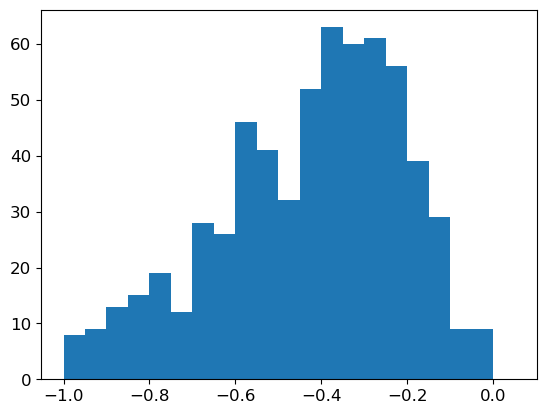

In [50]:
plt.hist( (d2-d1)/d1, np.arange(-1, 0.1, 0.05))
plt.show()

In [39]:
print('meanerr default', np.nanmean(d1))
print('meanerr calibrated', np.nanmean(d2))

meanerr default 9.163965761011418
meanerr calibrated 5.479268978792822


In [55]:
print('meanerr default', np.nanmean(d1))
print('meanerr calibrated', np.nanmean(d2))
print(np.sum(d1>d2)/len(d1))
print(d1[97],d2[97])

meanerr default 9.315966629186603
meanerr calibrated 5.159422684210527
1.0
2.9797510000000003 2.2062295


In [61]:
print('defa maxmerr / mae', np.nanmean(maxmerr_stat[:,0]), np.nanmean(mae_stat[:,0]))
print('calib maxmerr / mae', np.nanmean(maxmerr_stat[:,1]), np.nanmean(mae_stat[:,1]))

defa maxmerr / mae 10.632122735247208 7.999810523125997
calib maxmerr / mae 4.514188497607655 5.804656870813397


# Plot runoff curve of a selected basin

In [69]:
b = 97
files_defa = glob.glob(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich/level1_{b}_OSTRICHcalib/archive/PreserveModelOutput/Run_0/*.h0*.nc')
files_defa.sort()

files_calib = glob.glob(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich/level1_{b}_OSTRICHcalib/archive/PreserveBestModel/*.h0*.nc')
files_calib.sort()


In [79]:
df_obs = pd.read_csv("/glade/work/guoqiang/CTSM_CAMELS/CAMLES_Qobs/02056900_streamflow_qc.txt", delim_whitespace=True,header=None)
df_obs

,0,1,2,3,4,5
0,2056900,1980,1,1,106.0,A
1,2056900,1980,1,2,106.0,A
2,2056900,1980,1,3,105.0,A
3,2056900,1980,1,4,105.0,A
4,2056900,1980,1,5,114.0,A
...,...,...,...,...,...,...
12779,2056900,2014,12,27,-999.0,M
12780,2056900,2014,12,28,-999.0,M
12781,2056900,2014,12,29,-999.0,M
12782,2056900,2014,12,30,-999.0,M


In [70]:
ds_defa = xr.open_mfdataset(files_defa)
ds_calib = xr.open_mfdataset(files_calib)

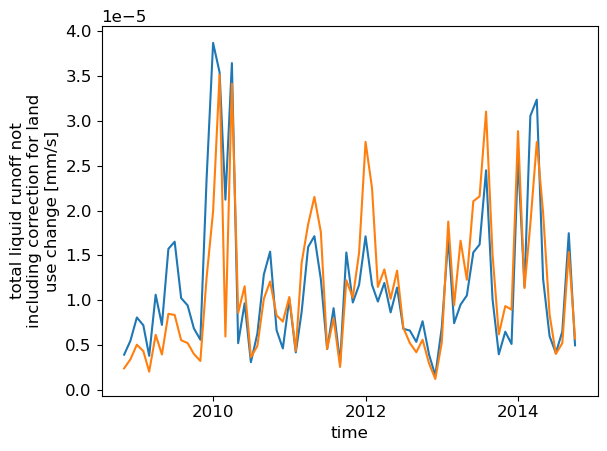

In [75]:
ds_defa.QRUNOFF.isel(lndgrid=0).plot()
ds_calib.QRUNOFF.isel(lndgrid=0).plot()